# Система прогнозирования бронирования отелей

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Шаг 1. Откроем файлы с данными

Откроем и проведем певичный анализ имеющихся данных

In [ ]:
data_train = pd.read_csv('/content/sample_data/hotel_train.csv')
data_test = pd.read_csv('/content/sample_data/hotel_test.csv')

In [ ]:
display(data_train)
data_train.info()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0.0,0.0,0.0,A,0.0,0.0,Transient,0.0,0.0,1.0
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0.0,0.0,0.0,A,0.0,0.0,Transient,0.0,1.0,2.0
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0.0,0.0,0.0,C,0.0,0.0,Transient,0.0,0.0,2.0
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0.0,0.0,0.0,C,0.0,0.0,Transient,0.0,1.0,2.0
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0.0,0.0,0.0,A,0.0,0.0,Transient,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28156,36096,1,205.0,2016,May,23,29,2,1,2.0,...,0.0,0.0,0.0,A,0.0,0.0,Transient,0.0,0.0,3.0
28157,36097,1,30.0,2016,May,23,29,2,1,2.0,...,0.0,0.0,0.0,A,1.0,0.0,Transient,0.0,1.0,3.0
28158,36098,1,205.0,2016,May,23,29,2,1,2.0,...,0.0,0.0,0.0,A,0.0,0.0,Transient,0.0,0.0,3.0
28159,36099,1,205.0,2016,May,23,29,2,1,2.0,...,0.0,0.0,0.0,A,0.0,0.0,Transient,0.0,0.0,3.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28161 entries, 0 to 28160
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              28161 non-null  int64  
 1   is_canceled                     28161 non-null  int64  
 2   lead_time                       28161 non-null  float64
 3   arrival_date_year               28161 non-null  int64  
 4   arrival_date_month              28161 non-null  object 
 5   arrival_date_week_number        28161 non-null  int64  
 6   arrival_date_day_of_month       28161 non-null  int64  
 7   stays_in_weekend_nights         28161 non-null  int64  
 8   stays_in_week_nights            28161 non-null  int64  
 9   adults                          28160 non-null  float64
 10  children                        28160 non-null  float64
 11  babies                          28160 non-null  float64
 12  meal                            

In [ ]:
display(data_test)
data_test.info()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1.0,74.0,2017.0,January,1.0,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,A,0.0,0.0,Transient,0.0,0.0,1.0
1,6087,1.0,62.0,2017.0,January,1.0,1.0,2.0,2.0,2.0,...,0.0,0.0,0.0,A,0.0,0.0,Transient,0.0,1.0,4.0
2,6088,1.0,62.0,2017.0,January,1.0,1.0,2.0,2.0,2.0,...,0.0,0.0,0.0,A,0.0,0.0,Transient,0.0,1.0,4.0
3,6089,1.0,71.0,2017.0,January,1.0,1.0,2.0,2.0,1.0,...,0.0,0.0,0.0,A,0.0,0.0,Transient,0.0,1.0,4.0
4,6090,1.0,172.0,2017.0,January,1.0,1.0,2.0,5.0,2.0,...,0.0,0.0,0.0,A,0.0,0.0,Transient,0.0,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28666,94158,0.0,7.0,2017.0,June,26.0,27.0,0.0,1.0,1.0,...,0.0,0.0,0.0,A,0.0,0.0,Transient,0.0,1.0,1.0
28667,94159,0.0,25.0,2017.0,June,26.0,27.0,0.0,1.0,2.0,...,0.0,0.0,0.0,A,1.0,0.0,Transient-Party,0.0,0.0,1.0
28668,94160,0.0,7.0,2017.0,June,26.0,27.0,0.0,1.0,1.0,...,0.0,0.0,0.0,A,0.0,0.0,Transient,0.0,1.0,1.0
28669,94161,0.0,348.0,2017.0,June,26.0,25.0,2.0,1.0,2.0,...,0.0,0.0,0.0,D,0.0,0.0,Transient,0.0,2.0,3.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28671 entries, 0 to 28670
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              28671 non-null  int64  
 1   is_canceled                     28670 non-null  float64
 2   lead_time                       28670 non-null  float64
 3   arrival_date_year               28670 non-null  float64
 4   arrival_date_month              28670 non-null  object 
 5   arrival_date_week_number        28670 non-null  float64
 6   arrival_date_day_of_month       28670 non-null  float64
 7   stays_in_weekend_nights         28670 non-null  float64
 8   stays_in_week_nights            28670 non-null  float64
 9   adults                          28670 non-null  float64
 10  children                        28670 non-null  float64
 11  babies                          28670 non-null  float64
 12  meal                            

### Шаг 2. Предобработка и исследовательский анализ данных

В датасетах data_test и data_train присутствует по одной строке с пропуском, удалим эти данные

In [ ]:
data_test = data_test.dropna(axis=0, how='any')
data_train = data_train.dropna(axis=0, how='any')
print(data_train.info())
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28160 entries, 0 to 28159
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              28160 non-null  int64  
 1   is_canceled                     28160 non-null  int64  
 2   lead_time                       28160 non-null  float64
 3   arrival_date_year               28160 non-null  int64  
 4   arrival_date_month              28160 non-null  object 
 5   arrival_date_week_number        28160 non-null  int64  
 6   arrival_date_day_of_month       28160 non-null  int64  
 7   stays_in_weekend_nights         28160 non-null  int64  
 8   stays_in_week_nights            28160 non-null  int64  
 9   adults                          28160 non-null  float64
 10  children                        28160 non-null  float64
 11  babies                          28160 non-null  float64
 12  meal                            

Проверим столбцы на пропуски, дубли, соответствие указанным типам данным и уникальные и подозрительные, или неподхоядище значения, думаю сперва нужно будет выделить столбцы, которые важны анм прежде всего и обработать их. Также думаю, важно будет построить несколько диаграм, для понимания взаимосвязей между данными.

- Проверим соответствии типа переменной ее фактическому значению в столбце

In [ ]:
data_test['lead_time'] = data_test['lead_time'].astype(int)
data_test['adults'] = data_test['adults'].astype(int)
data_train['lead_time'] = data_train['lead_time'].astype(int)
data_train['adults'] = data_train['adults'].astype(int)
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28670 entries, 0 to 28669
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              28670 non-null  int64  
 1   is_canceled                     28670 non-null  float64
 2   lead_time                       28670 non-null  int64  
 3   arrival_date_year               28670 non-null  float64
 4   arrival_date_month              28670 non-null  object 
 5   arrival_date_week_number        28670 non-null  float64
 6   arrival_date_day_of_month       28670 non-null  float64
 7   stays_in_weekend_nights         28670 non-null  float64
 8   stays_in_week_nights            28670 non-null  float64
 9   adults                          28670 non-null  int64  
 10  children                        28670 non-null  float64
 11  babies                          28670 non-null  float64
 12  meal                            

lead_time - указаны только целые числа, так как речь идет о кол-ве дней, необходимо заменить на int

adults - должно быть целое число, так как половина взрослого невозможна, необходимо заменить на int

- Проверим категориальные переменные на нетипичные значения и пропуски

In [ ]:
print(data_train['adults'].value_counts())
print(data_train['babies'].value_counts())
print(data_train['children'].value_counts())
print(data_train['country'].value_counts())
print(data_train['customer_type'].value_counts())
print(data_train['distribution_channel'].value_counts())
print(data_train['is_canceled'].value_counts())
print(data_train['is_repeated_guest'].value_counts())
print(data_train['meal'].value_counts())
print(data_train['required_car_parking_spaces'].value_counts())
print(data_train['reserved_room_type'].value_counts())
print(data_train['total_of_special_requests'].value_counts())
print(data_train['arrival_date_year'].value_counts())
print(data_train['arrival_date_month'].value_counts())
print(data_train['arrival_date_week_number'].value_counts())
print(data_train['arrival_date_day_of_month'].value_counts())
display(data_train.query('adults == 0 & babies == 0 & children == 0'))

2    22130
1     5328
3      654
0       44
4        4
Name: adults, dtype: int64
0.0     27884
1.0       273
2.0         2
10.0        1
Name: babies, dtype: int64
0.0    26804
1.0      702
2.0      646
3.0        8
Name: children, dtype: int64
PRT    14008
GBR     2883
ESP     2715
FRA     1589
DEU     1048
       ...  
ZWE        1
CIV        1
CRI        1
STP        1
SYR        1
Name: country, Length: 121, dtype: int64
Transient          18989
Transient-Party     7796
Contract            1255
Group                120
Name: customer_type, dtype: int64
TA/TO        22530
Direct        3931
Corporate     1695
GDS              4
Name: distribution_channel, dtype: int64
0    17553
1    10607
Name: is_canceled, dtype: int64
0.0    27518
1.0      642
Name: is_repeated_guest, dtype: int64
BB           21805
HB            4529
SC             860
SC             515
FB             451
Name: meal, dtype: int64
0.0    25637
1.0     2513
2.0       10
Name: required_car_parking_spaces, dtype: 

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
23770,31710,0,48,2016,February,9,21,2,4,0,...,0.0,0.0,0.0,B,2.0,0.0,Transient-Party,0.0,0.0,6.0
26878,34818,0,122,2016,May,19,5,2,4,0,...,0.0,0.0,0.0,E,3.0,0.0,Transient,0.0,0.0,6.0
26879,34819,0,122,2016,May,19,5,2,4,0,...,0.0,0.0,0.0,E,3.0,0.0,Transient,0.0,0.0,6.0


In [ ]:
print(data_test['adults'].value_counts())
print(data_test['babies'].value_counts())
print(data_test['booking_changes'].value_counts())
print(data_test['children'].value_counts())
print(data_test['country'].value_counts())
print(data_test['customer_type'].value_counts())
print(data_test['distribution_channel'].value_counts())
print(data_test['is_canceled'].value_counts())
print(data_test['is_repeated_guest'].value_counts())
print(data_test['meal'].value_counts())
print(data_test['required_car_parking_spaces'].value_counts())
print(data_test['reserved_room_type'].value_counts())
print(data_test['total_of_special_requests'].value_counts())
print(data_test['arrival_date_year'].value_counts())
print(data_test['arrival_date_month'].value_counts())
print(data_test['arrival_date_week_number'].value_counts())
print(data_test['arrival_date_day_of_month'].value_counts())
display(data_test.query('adults == 0 & babies == 0 & children == 0'))

2    21424
1     5751
3     1431
0       56
4        8
Name: adults, dtype: int64
0.0    28517
1.0      149
2.0        4
Name: babies, dtype: int64
0.0     24781
1.0      2540
2.0       978
3.0       229
4.0        94
5.0        25
6.0        15
7.0         3
18.0        1
15.0        1
16.0        1
14.0        1
8.0         1
Name: booking_changes, dtype: int64
0.0    27018
1.0     1087
2.0      561
3.0        4
Name: children, dtype: int64
PRT    9424
GBR    3409
FRA    2975
DEU    1922
ESP    1694
       ... 
JEY       1
MYT       1
BGD       1
GAB       1
SDN       1
Name: country, Length: 134, dtype: int64
Transient          24236
Transient-Party     3920
Contract             357
Group                157
Name: customer_type, dtype: int64
TA/TO        23989
Direct        3076
Corporate     1528
GDS             77
Name: distribution_channel, dtype: int64
0.0    16080
1.0    12590
Name: is_canceled, dtype: int64
0.0    27659
1.0     1011
Name: is_repeated_guest, dtype: int64
BB     

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
18333,73610,0.0,55,2017.0,March,10.0,5.0,2.0,0.0,0,...,1.0,1.0,9.0,A,2.0,0.0,Transient,1.0,0.0,2.0
21214,86706,0.0,50,2017.0,March,9.0,1.0,0.0,3.0,0,...,0.0,0.0,0.0,A,1.0,0.0,Transient,0.0,1.0,3.0
25596,91088,0.0,33,2017.0,May,19.0,9.0,0.0,1.0,0,...,0.0,0.0,0.0,E,3.0,0.0,Transient,0.0,0.0,1.0
28463,93955,0.0,26,2017.0,June,25.0,19.0,1.0,4.0,0,...,0.0,0.0,0.0,D,2.0,0.0,Transient,0.0,1.0,5.0


In [ ]:
data_train['meal'].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

**Выводы:**
- Мы видим, что представленные данные в тренировочной выборек даны только за 2015 - 2016й год, а в тестовой за 2017
- В столбце с колличеством взрослых набладается ряд пропусков, так как бронирование отеля детьми до 14 лет невозможно, эти поля необходимо заполнить медианным и значениями
- Также есть ряд полей, где ни указано ни одного постояльца в столбцах: adults, babies и children нет вообще, будем считать эти строки пропусками в данных и удалим их
- Также, в столбце babies, наблюдается несколько выбросов с аномально высоким кооличеством маледнцев, 10 и 9, это всего два случая, которые нужно удалить
- В столбце meal есть дупликат, значение SC повторяется из-за лишних пробелов, объединим их в одну категорию

In [ ]:
# Заполняем пропуски в столбце с колл-вом взрослых медианным значением,  и удаляем строки с нулевым значением в столбце
data_train = data_train.drop(data_train.query('adults == 0 & babies == 0 & children == 0').index)
data_train.loc[data_train['adults'] == 0, 'adults'] = data_train['adults'].median()
data_train['meal'] = data_train['meal'].str.strip()

data_test = data_test.drop(data_test.query('adults == 0 & babies == 0 & children == 0').index)
data_test.loc[data_test['adults'] == 0, 'adults'] = data_test['adults'].median()
data_test['meal'] = data_test['meal'].str.strip()


- Находим и при необходимости устраняем редкие значения и выбросы из числовых пременных

<Axes: >

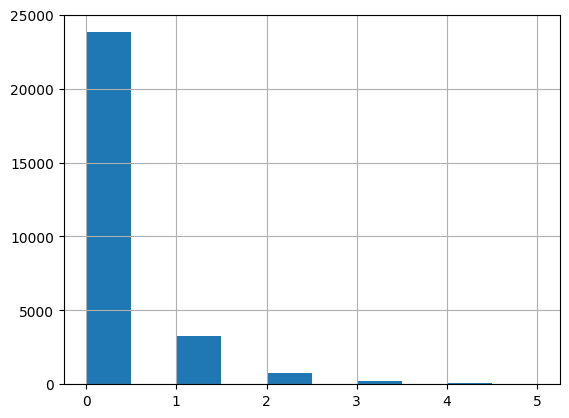

In [ ]:
data_train['booking_changes'].hist(range=(0,5))

<Axes: >

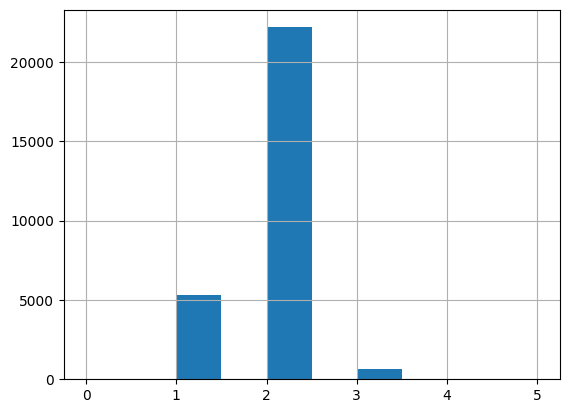

In [ ]:
data_train['adults'].hist(range=(0,5))

<Axes: >

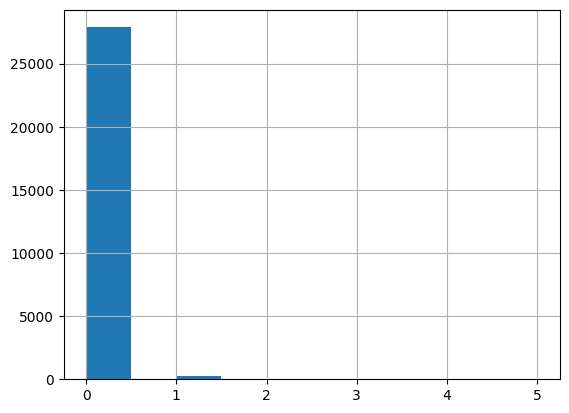

In [ ]:
data_train['babies'].hist(range=(0,5))

<Axes: >

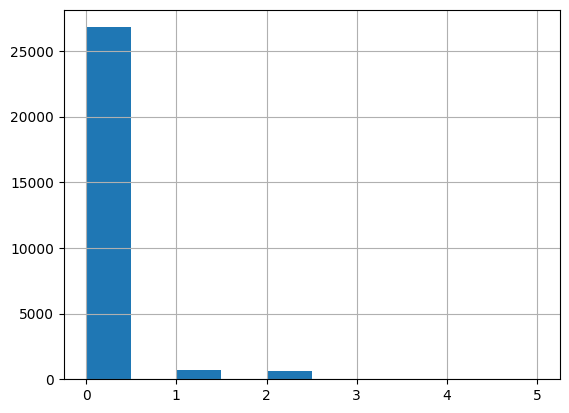

In [ ]:
data_train['children'].hist(range=(0,5))

<Axes: >

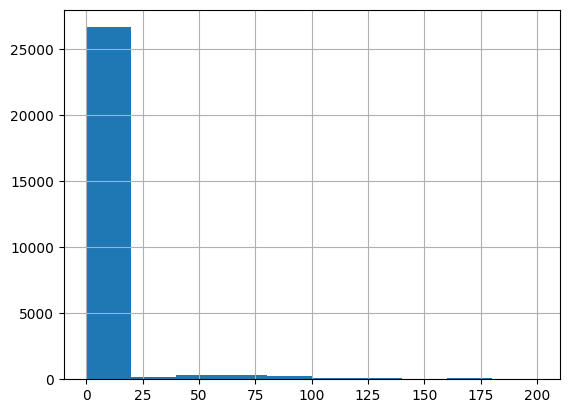

In [ ]:
data_train['days_in_waiting_list'].hist(range=(0,200))

<Axes: >

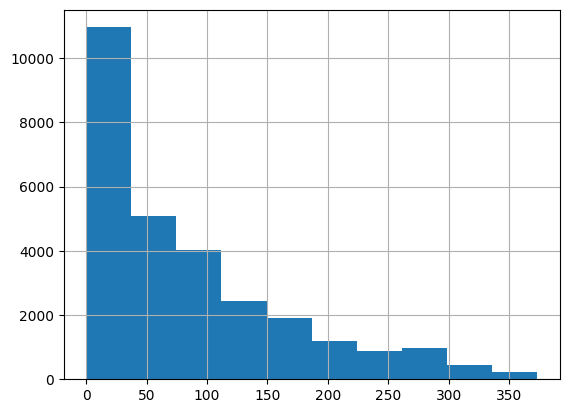

In [ ]:
data_train['lead_time'].hist()

<Axes: >

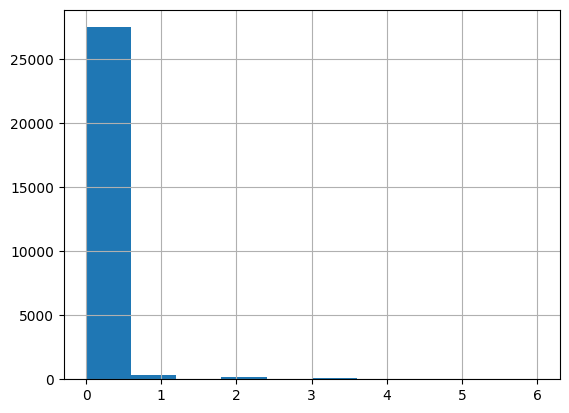

In [ ]:
data_train['previous_bookings_not_canceled'].hist(range=(0,6))

<Axes: >

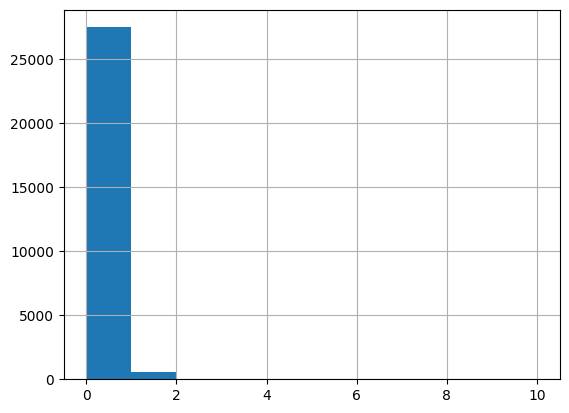

In [ ]:
data_train['previous_cancellations'].hist(range=(0,10))

<Axes: >

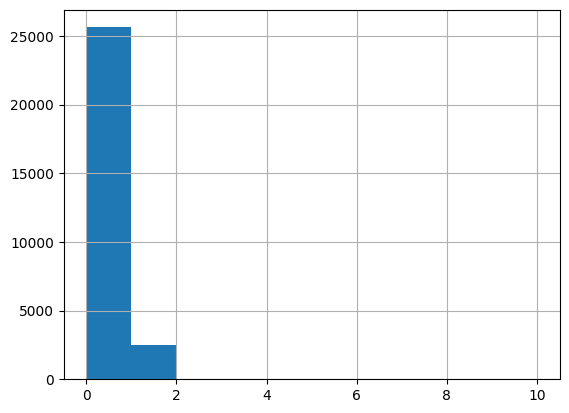

In [ ]:
data_train['required_car_parking_spaces'].hist(range=(0,10))

<Axes: >

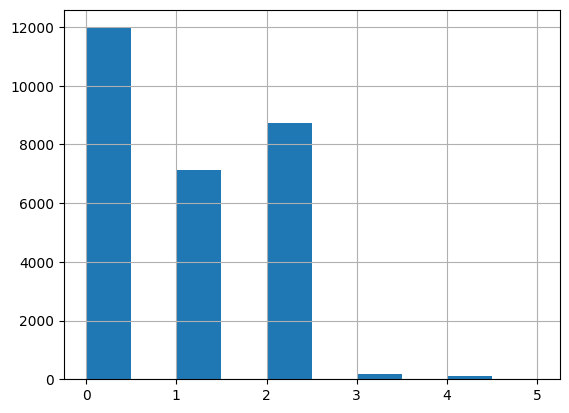

In [ ]:
data_train['stays_in_weekend_nights'].hist(range=(0,5))

<Axes: >

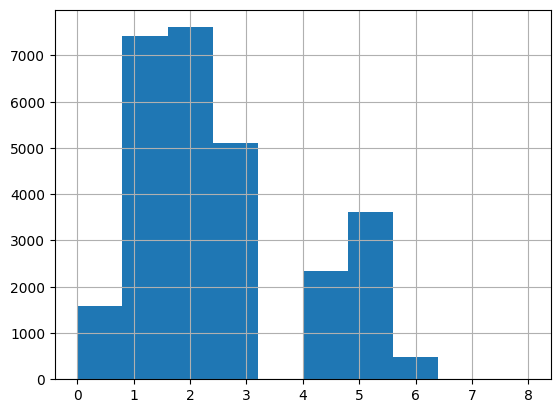

In [ ]:
data_train['stays_in_week_nights'].hist(range=(0,8))

<Axes: >

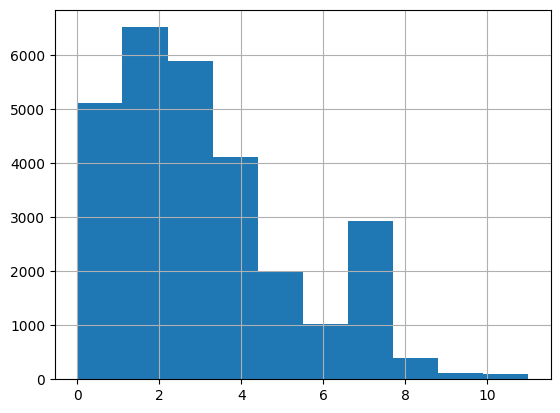

In [ ]:
data_train['total_nights'].hist(range=(0,11))

<Axes: >

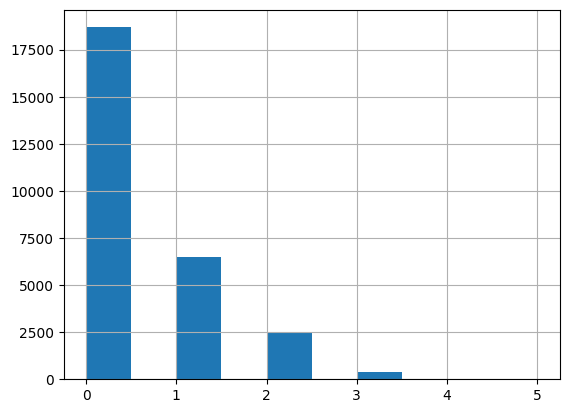

In [ ]:
data_train['total_of_special_requests'].hist(range=(0,5))

Большей частью, распределение графиков можно характеризовать как нормальное, однако наблюдается ряд выбросов с аномально высокими значениями в следующих столбцах:
- booking_changes- больше 3х и 4х
- days_in_waiting_list более 150
- stays_in_weekend_nights более 4х
- total_of_special_requests более 4х
- babies, более 9 детей
Удалим выбросы в этих столбцах.

In [ ]:
data_train = data_train.query('babies < 9 or babies.isna()')
data_train = data_train.query('booking_changes < 3 or booking_changes.isna()')
data_train = data_train.query('days_in_waiting_list < 150 or days_in_waiting_list.isna()')
data_train = data_train.query('stays_in_weekend_nights < 4 or stays_in_weekend_nights.isna()')
data_train = data_train.query('total_of_special_requests < 4 or total_of_special_requests.isna()')

На основе результатов, найденных при анализе тренировочной выборки, внесем схожие корректировки в данные тестовой выборки

In [ ]:
data_test = data_test.query('babies < 9 or babies.isna()')
data_test = data_test.query('booking_changes < 3 or booking_changes.isna()')
data_test = data_test.query('days_in_waiting_list < 150 or days_in_waiting_list.isna()')
data_test = data_test.query('stays_in_weekend_nights < 4 or stays_in_weekend_nights.isna()')
data_test = data_test.query('total_of_special_requests < 4 or total_of_special_requests.isna()')

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Оценим текущую прибыль отеля без внедрения депозитов на примере тестовой выборки, чтобы понять насколько наша модель может ее повысить, также учтем в расчетах сезонный коэффециент, известный нам благодая данным от заказчика.
Нам известно, что в ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.

In [ ]:
data_test_incom = data_test

In [ ]:
def season_pricer(row):

    month = row['arrival_date_month']

    if 'December' in month or 'January' in month or 'February' in month:
        return 1

    elif 'June' in month or 'July' in month or 'August' in month:
        return 1.4

    else:
        return 1.2

data_test_incom['season_price'] = data_test.apply(season_pricer, axis=1)
data_test_incom['season_price'].value_counts()



1.2    14142
1.4     7391
1.0     6593
Name: season_price, dtype: int64

In [ ]:
def room_pricer(row):
    room = row['reserved_room_type']

    if 'A' in room:
        return 1000

    elif 'B' in room:
        return 800

    elif 'C' in room:
        return 600

    elif 'D' in room:
        return 550

    elif 'E' in room:
        return 500

    elif 'F' in room:
        return 450

    elif 'G' in room:
        return 350

data_test_incom['room_price'] = data_test.apply(room_pricer, axis=1)
data_test_incom['room_price'].value_counts()

1000    20537
550      5085
500      1477
450       435
350       266
600       191
800       135
Name: room_price, dtype: int64

In [ ]:
def service_pricer(row):
    room = row['reserved_room_type']

    if 'A' in room:
        return 400

    elif 'B' in room or 'C' in room:
        return 350

    else:
        return 150

data_test_incom['service_price'] = data_test.apply(service_pricer, axis=1)
data_test_incom['service_price'].value_counts()

400    20537
150     7263
350      326
Name: service_price, dtype: int64

In [ ]:
def profit_count(row):
    if row['is_canceled'] == 0:
        profit = (row['total_nights'] * row['room_price'] * row['season_price'])
        - (row['service_price'] * (1+row['total_nights']) // 2)
        return profit

    else:
        profit = -1 * (row['room_price'] * row['season_price'] + row['service_price'])
        return profit

data_test_incom['profit'] = data_test_incom.apply(profit_count, axis=1)
data_test_incom['profit'].sum()

31165980.0

Итого, без внедрения модели, за год отель принесет прибыль в размере- 45 084 170 рублей

### Шаг 4. Разработка модели ML

- Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.
- Выберите метрику для обучения.
- Оцените прибыль, которую принесёт выбранная модель за год.

Первично проведем подготовку данных, к анализу, а именно:
- Удаляем лишние признаки
- Выделяем целевой признак
- Кодируем категориальные переменные, в тестовой и тренировочной выборках
- Приведем признаки к единому масштабу на всех выборках, включая тестовую
- Проверим баланс классов и в случае дисбаланса, устраним его, только на тренировочной выборке

#### Подготовка признаков

In [ ]:
# Так как в дальнейшем данные из датасета могут нам понадобитсья в своем изначальном виде, до начала работы, сохраним их в отдельные переменные
data_train_ml = data_train
data_test_ml = data_test

1. Удалим лишние признаки из датасета, а именно:
id и total_nights (так total_nights, по сути дублирует кол-во ночей в выходные и в будни, являясь их суммой)

In [ ]:
data_train_ml = data_train_ml.drop(['id', 'total_nights'], axis=1)
data_test_ml = data_test_ml.drop(['id', 'total_nights'], axis=1)

2. Выделим в тестовой и тренировочной выборке целевой признак

In [ ]:
target_train = data_train_ml['is_canceled']
features_train = data_train_ml.drop('is_canceled', axis=1)

target_test = data_test_ml['is_canceled']
features_test = data_test_ml.drop('is_canceled', axis=1)

3. Кодируем категориальные переменные, в тестовой и тренировочной выборках + приводим признаки к единому масштабу
Категориальные переменные: arrival_date_month, reserved_room_type, customer_type, country, distribution_channel, meal
Используем технику OHE, так как в тестовом датафрейме может не быть некоторых категорий, присутсвующих в тренировочном датафрейме

In [ ]:
var_categorical = ['arrival_date_month', 'reserved_room_type', 'customer_type', 'country', 'distribution_channel', 'meal']
var_numeric = ['adults', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'babies', 'booking_changes', 'children', 'days_in_waiting_list', 'is_repeated_guest', 'lead_time', 'previous_bookings_not_canceled', 'previous_cancellations', 'required_car_parking_spaces', 'stays_in_weekend_nights', 'stays_in_week_nights', 'total_of_special_requests']

encoder = OneHotEncoder(handle_unknown='ignore')

features_train_ohe = pd.DataFrame(
        encoder.fit_transform(features_train[var_categorical]).toarray(),
        columns=encoder.get_feature_names_out()
)

scaler = StandardScaler()

features_train_numeric = pd.DataFrame(
        scaler.fit_transform(features_train[var_numeric]),
        columns=var_numeric
   )

features_train = features_train_ohe.join(features_train_numeric)
features_train


,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,...,children,days_in_waiting_list,is_repeated_guest,lead_time,previous_bookings_not_canceled,previous_cancellations,required_car_parking_spaces,stays_in_weekend_nights,stays_in_week_nights,total_of_special_requests
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.210419,-0.208008,-0.151792,-0.912282,-0.108632,-0.074269,-0.312698,-1.034697,-0.938050,-0.633951
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.210419,-0.208008,-0.151792,-0.827018,-0.108632,-0.074269,-0.312698,-1.034697,-0.265177,0.763400
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.210419,-0.208008,-0.151792,-0.997546,-0.108632,-0.074269,-0.312698,-1.034697,-0.265177,-0.633951
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.210419,-0.208008,-0.151792,-0.887921,-0.108632,-0.074269,-0.312698,-1.034697,-0.265177,0.763400
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.210419,-0.208008,-0.151792,0.037801,-0.108632,-0.074269,-0.312698,-1.034697,0.407697,0.763400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.210419,-0.208008,-0.151792,1.499469,-0.108632,-0.074269,-0.312698,1.268360,-0.938050,-0.633951
27436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.210419,-0.208008,-0.151792,1.499469,-0.108632,-0.074269,-0.312698,1.268360,-0.938050,-0.633951
27437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.210419,-0.208008,-0.151792,-0.632129,-0.108632,-0.074269,-0.312698,1.268360,-0.938050,0.763400
27438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.210419,-0.208008,-0.151792,1.499469,-0.108632,-0.074269,-0.312698,1.268360,-0.938050,-0.633951


In [ ]:
features_test_ohe = pd.DataFrame(
        encoder.transform(features_test[var_categorical]).toarray(),
        columns=encoder.get_feature_names_out()
)

features_test_numeric = pd.DataFrame(
        scaler.transform(features_test[var_numeric]),
        columns=var_numeric
   )

features_test = features_test_ohe.join(features_test_numeric)
features_test

,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,...,children,days_in_waiting_list,is_repeated_guest,lead_time,previous_bookings_not_canceled,previous_cancellations,required_car_parking_spaces,stays_in_weekend_nights,stays_in_week_nights,total_of_special_requests
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.210419,-0.208008,-0.151792,-0.096185,-0.108632,-0.074269,-0.312698,0.116831,-1.610924,-0.633951
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.210419,-0.208008,-0.151792,-0.242351,-0.108632,-0.074269,-0.312698,1.268360,-0.265177,0.763400
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.210419,-0.208008,-0.151792,-0.242351,-0.108632,-0.074269,-0.312698,1.268360,-0.265177,0.763400
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.210419,-0.208008,-0.151792,-0.132726,-0.108632,-0.074269,-0.312698,1.268360,-0.265177,0.763400
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.210419,-0.208008,-0.151792,1.097510,-0.108632,-0.074269,-0.312698,1.268360,1.753443,-0.633951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28121,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.210419,-0.208008,-0.151792,-0.729574,-0.108632,-0.074269,-0.312698,-1.034697,-0.938050,-0.633951
28122,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.210419,-0.208008,-0.151792,-0.912282,-0.108632,-0.074269,-0.312698,-1.034697,-0.938050,0.763400
28123,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.210419,-0.208008,-0.151792,-0.693032,-0.108632,-0.074269,-0.312698,-1.034697,-0.938050,-0.633951
28124,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.210419,-0.208008,-0.151792,-0.912282,-0.108632,-0.074269,-0.312698,-1.034697,-0.938050,0.763400


#### Обучене моделей и выявлениенаилучшей из них

Однако, спева подберем метрику, наиболее подходящую под модель в данном кейсе.
Наиболее подходящей для нас метрикой, в данном случае явялется соотношение полноты и точности- f1, так как прежде всего на прибыль будет влиять то, насколько верно модель, сможет определить клиента, склонного к отмене брони, от чего и будет зависеть наша выручка и перспективы внедрения системы, однако мы не можем просто предлагать бронирование всем поряд, так как это может раздражать постоянный клиентов, поэтому полнота не менее важна, почему нам и нужно выбрать метрику- F1.

1. Модель Логистической Регрессии

In [ ]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')

scores = cross_val_score(model, features_train, target_train, scoring='f1')
final_score = scores.mean()

print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: 0.4543298044235821


2. Модель дерева решений

In [ ]:
best_result = 0
best_depth = 0
best_leaf = 0

for depth in range(1, 20):
    for leaf in range (1, 20):
        model = DecisionTreeClassifier(max_depth=depth, min_samples_leaf = leaf, random_state=12345)
        scores = cross_val_score(model, features_train, target_train, scoring='f1')
        result = scores.mean()

        if result > best_result:
            best_result   = result
            best_depth = depth
            best_leaf = leaf

print('Лучшая глубина-', best_depth, ', параметр min_samples_leaf- ', best_leaf, 'и результат-', best_result)

Лучшая глубина- 5 , параметр min_samples_leaf-  1 и результат- 0.47374980677044476


3. Модель случайного леса

In [ ]:
best_result = 0
best_est = 0
best_depth = 0

for est in range(10, 60, 10):
    for depth in range (1, 6):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        scores = cross_val_score(model, features_train, target_train, scoring='f1')
        result = scores.mean()

        if result > best_result:
            best_result = result
            best_est = est
            best_depth = depth


print('Лучшая глубина-', best_depth, ',количество деревьев- ', best_est, 'и результат-', best_result)

Лучшая глубина- 5 ,количество деревьев-  20 и результат- 0.3750682933116778


4. Проведем тест на наилучшей из выбранных моделей, модели решающего дерева для анализа результатов работы модели на тестовой выборке.

In [ ]:
model = DecisionTreeClassifier(max_depth=4, random_state=12345)

model.fit(features_train, target_train)
predictions = model.predict(features_test)

print('Оценка качества модели:',f1_score(target_test, predictions))

Оценка качества модели: 0.620801805389619


#### Оценим прибыль, которую принесёт выбранная модель за год на примере тестовой выборки

- После внедрения модели на самом деле у нас есть 4 комбинации фактического значения и предсказания, на основе значений в столбце profit (которые мы уже создали для анализа выручки отеля) и profit_predicted (который создадим для анализа выручки по реультатам предсказания) :
- 0, 0 — постоялец заселился (то есть значение в profit положительное), модель предсказала, что он заселится. В этом случае прибыль отеля никак не меняется, в profit_predicted будет то же значение, что и в столбце profit, в котором мы указывали возможную выручку
- 0, 1 — постоялец заселился (то есть значение в profit положительное), модель предсказала, что он отменит. В этом случае постоялец внесёт предоплату, которая пойдёт в счёт оплаты, то есть в этом случае прибыль отеля тоже никак не меняется, в profit_predicted будет то же значение, что и в profit.
- 1, 0 — постоялец отменил бронь (то есть значение в profit отрицательное), модель предсказала, что он заселится, то есть предоплату с такого клиента не брали. В этом прибыль отеля тоже никак не меняется, отель потерял деньги, в profit_predicted будет то же отрицательное значение, что и в profit.
- 1, 1 — постоялец отменил бронь (то есть значение в profit отрицательное), модель предсказала, что он отменит, то есть с постояльца взяли предоплату, которая составляет 80% от стоимости одной ночи * на сезонный коэффициент + стоимость одной уборки. Для того, чтобы не делать долгие вычисления, можно просто умножить отрицательное значение в profit на 0.2, так мы получим разницу между потеренной выгодой отеля и предоплатой, с внедрением модели отель потеряет только 20% от той суммы, которую терял без модели.

In [ ]:
data_test_incom['predictions'] = predictions
develop_cost = 400000 # планируемая стоимость внедрения системы

def profit_predicted(row):
    for i in row:

        if row['is_canceled'] == 1 and row['predictions'] == 1:
            profit = row['profit'] * 0.2
            return profit

        else:
            return row['profit']

data_test_incom['profit_predicted'] = data_test_incom.apply(profit_predicted, axis=1)
predicted_incom = data_test_incom['profit_predicted'].sum() - develop_cost
predicted_difference = predicted_incom - data_test_incom['profit'].sum()

print('Расчетная прибыль, от внедрения модели за год, составит-', predicted_incom)
print('Что поможет повысить приыбль отеля на', predicted_difference, 'в год, по сравнению с выручкой до внедрения модели.')

Расчетная прибыль, от внедрения модели за год, составит- 41371884.0
Что поможет повысить приыбль отеля на 10205904.0 в год, по сравнению с выручкой до внедрения модели.


### Шаг 5. Портрет «ненадёжного» клиента

Чтобы выявить интересные взаимосвязи в днанных исследуем данные путем построения графиков дял визуализции результата и на основе этого предоставим рекомендации для бизнеса

При этом мы не будем изучать следующие столбцы, так как они не смогут помочь нам в построении рекомендаций: id, arrival_date_year, arrival_date_week_number, arrival_date_day_of_month.

Категориальный переменные, для удобства проанализируем, путем групировки, к категориальным переменным, относятся следующие столбцы: arrival_date_month, country, customer_type, distribution_channel, is_repeated_guest, meal, reserved_room_type

В качестве метрики мы используем среднее значение столбца- is_canceled, по отношению к проверяемому, столбцу, так как в каждом из них распределение не равномерно и данные могут различаться

Axes(0.125,0.11;0.775x0.77)
2    21591
1     5220
3      627
4        2
Name: adults, dtype: int64
Axes(0.125,0.11;0.775x0.77)
0.0    27179
1.0      260
2.0        1
Name: babies, dtype: int64
Axes(0.125,0.11;0.775x0.77)
0.0    23513
1.0     3203
2.0      724
Name: booking_changes, dtype: int64
Axes(0.125,0.11;0.775x0.77)
0.0    26141
1.0      657
2.0      634
3.0        8
Name: children, dtype: int64
Axes(0.125,0.11;0.775x0.77)
0.0      26069
58.0       164
31.0       102
87.0        74
111.0       70
63.0        67
77.0        63
101.0       60
3.0         59
50.0        54
91.0        50
39.0        38
93.0        38
122.0       36
75.0        36
69.0        35
60.0        34
98.0        29
65.0        27
120.0       25
57.0        24
48.0        24
20.0        23
21.0        22
96.0        20
79.0        20
47.0        17
99.0        15
85.0        15
49.0        13
41.0        13
125.0       11
55.0        10
40.0         9
56.0         8
38.0         8
59.0         8
34.0        

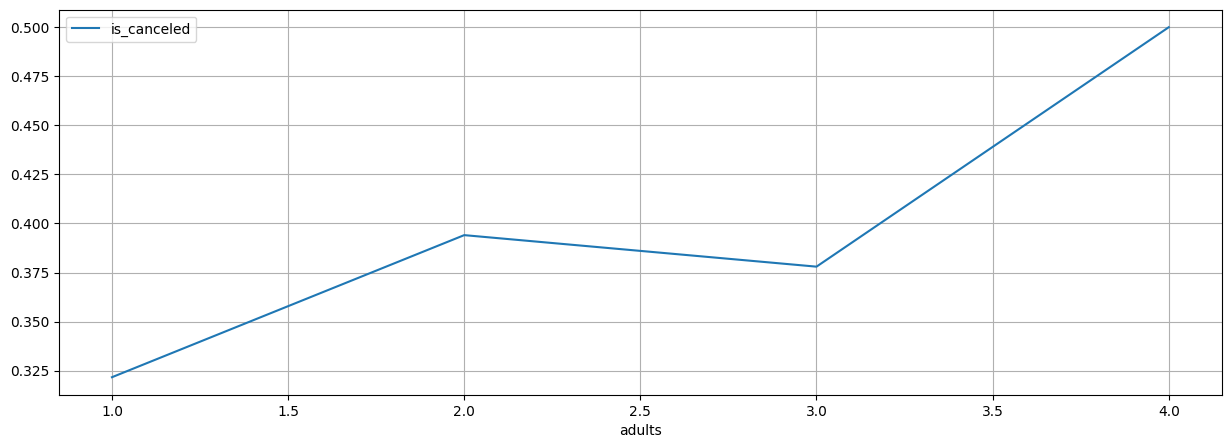

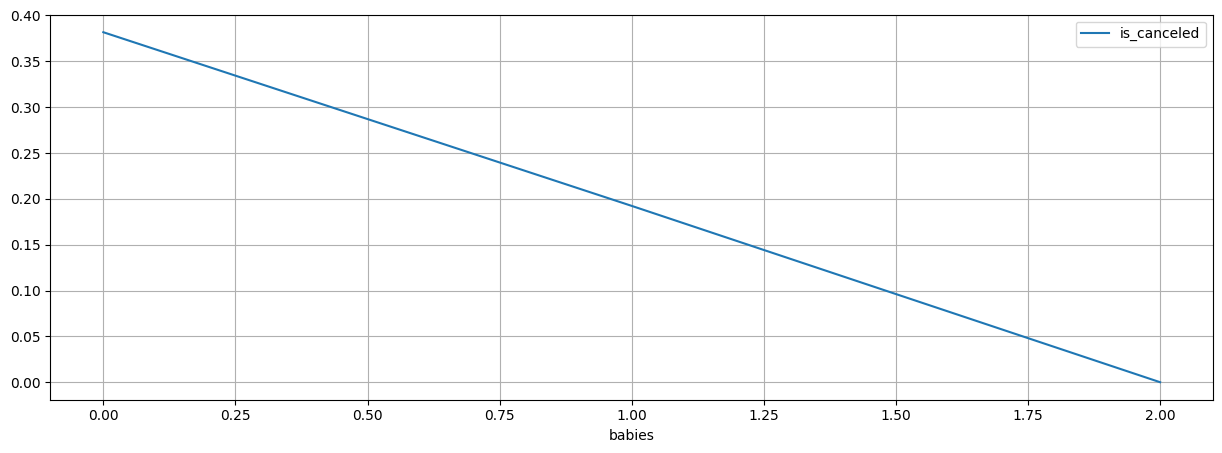

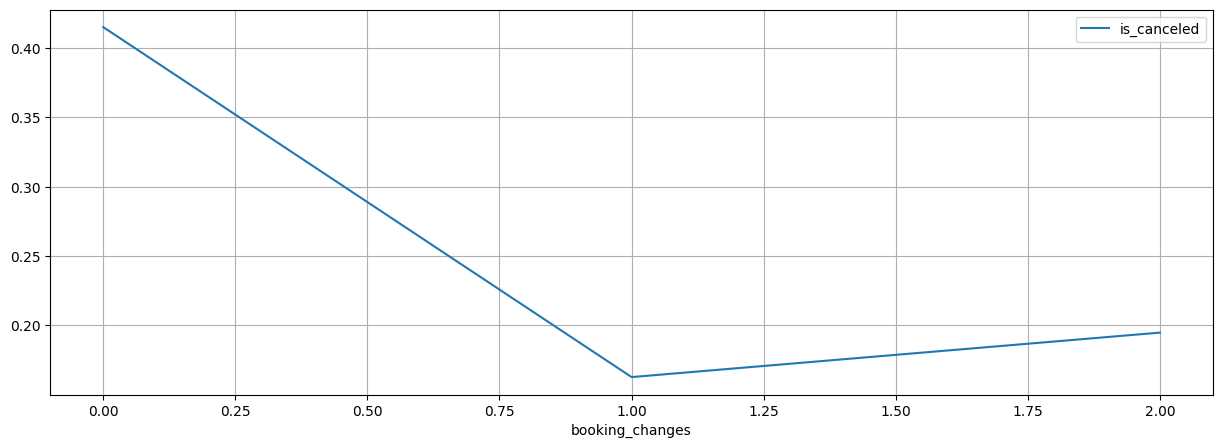

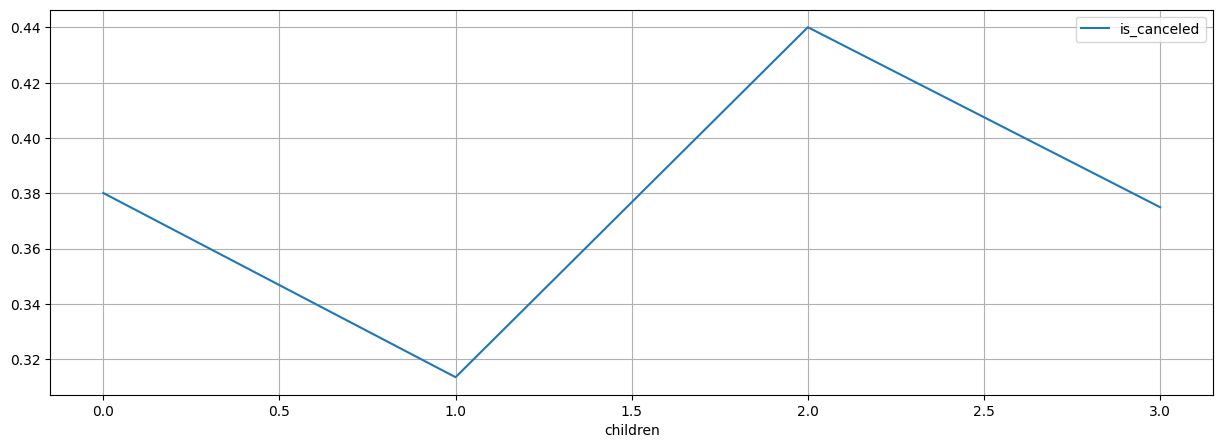

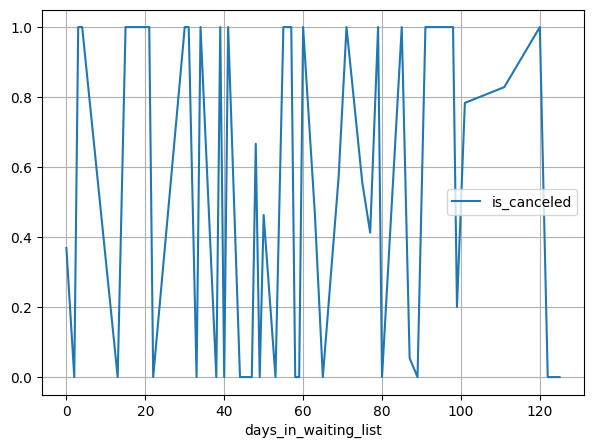

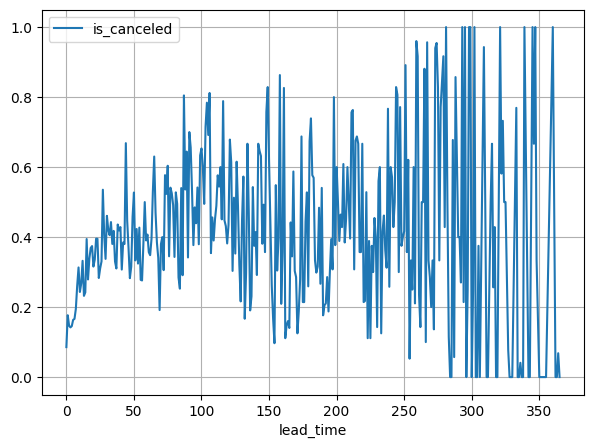

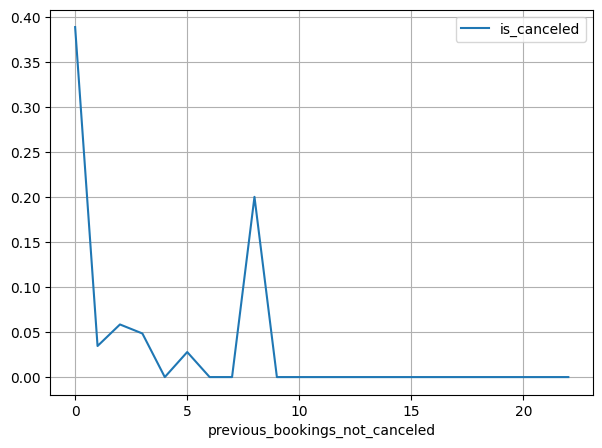

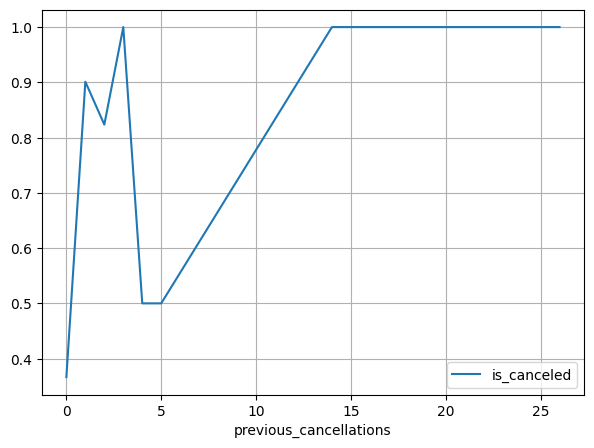

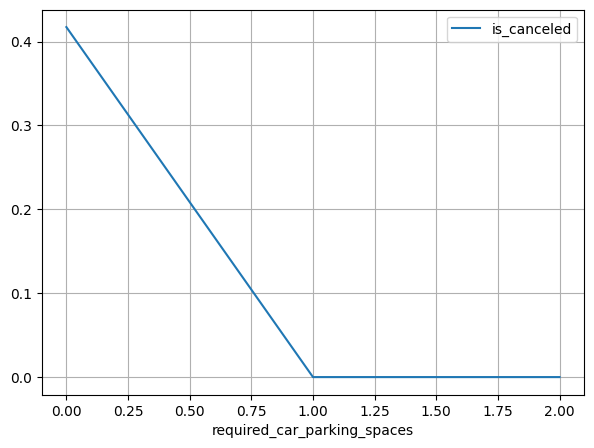

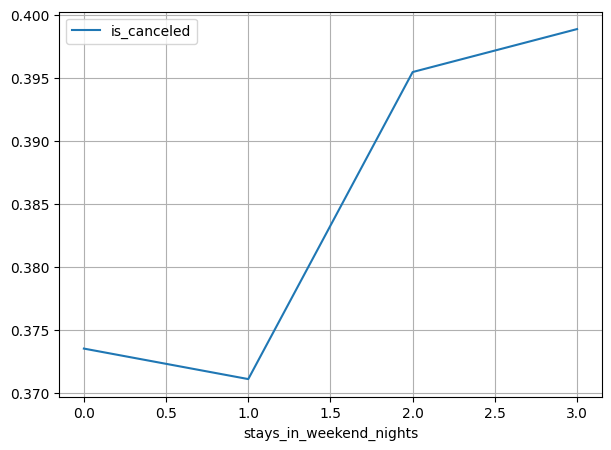

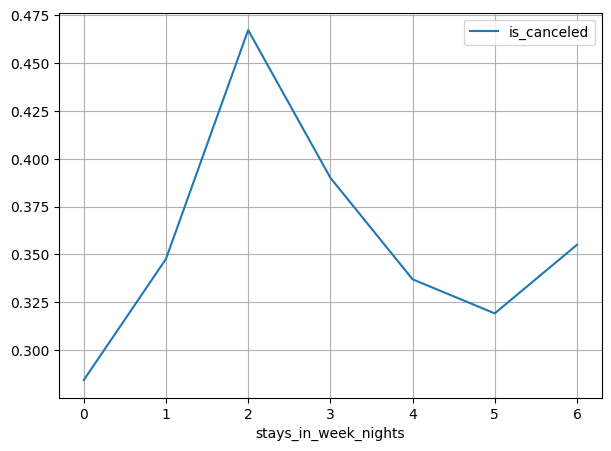

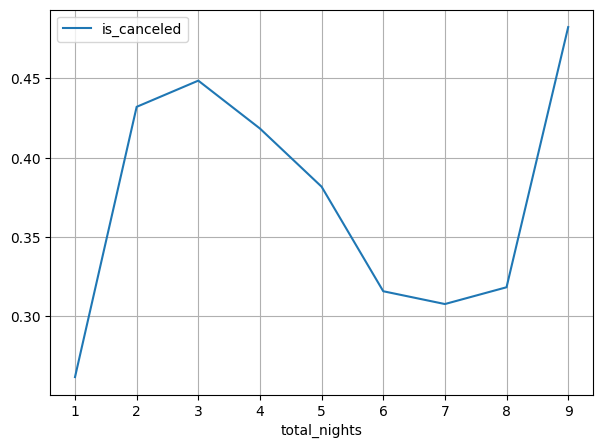

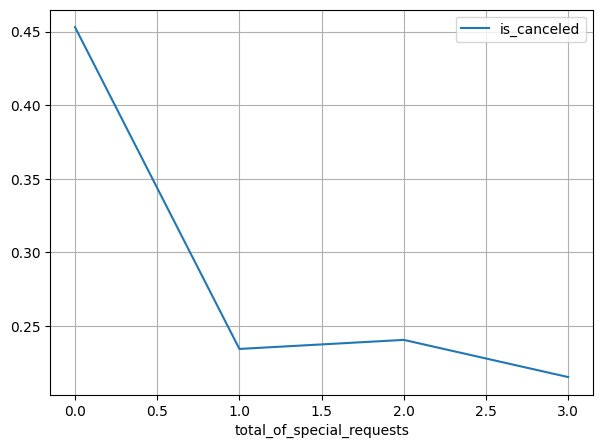

In [ ]:
print(data_train.pivot_table(index='adults',values='is_canceled', aggfunc='mean').plot(grid=True, figsize=(15, 5)))
print(data_train['adults'].value_counts())
print(data_train.pivot_table(index='babies',values='is_canceled', aggfunc='mean').plot(grid=True, figsize=(15, 5)))
print(data_train['babies'].value_counts())
print(data_train.pivot_table(index='booking_changes',values='is_canceled', aggfunc='mean').plot(grid=True, figsize=(15, 5)))
print(data_train['booking_changes'].value_counts())
print(data_train.pivot_table(index='children',values='is_canceled', aggfunc='mean').plot(grid=True, figsize=(15, 5)))
print(data_train['children'].value_counts())
print(data_train.pivot_table(index='days_in_waiting_list',values='is_canceled', aggfunc='mean').plot(grid=True, figsize=(7, 5)))
print(data_train['days_in_waiting_list'].value_counts())
print(data_train.pivot_table(index='lead_time',values='is_canceled', aggfunc='mean').plot(grid=True, figsize=(7, 5)))
print(data_train['lead_time'].value_counts())
print(data_train.pivot_table(index='previous_bookings_not_canceled',values='is_canceled', aggfunc='mean').plot(grid=True, figsize=(7, 5)))
print(data_train['previous_bookings_not_canceled'].value_counts())
print(data_train.pivot_table(index='previous_cancellations',values='is_canceled', aggfunc='mean').plot(grid=True, figsize=(7, 5)))
print(data_train['previous_cancellations'].value_counts())
print(data_train.pivot_table(index='required_car_parking_spaces',values='is_canceled', aggfunc='mean').plot(grid=True, figsize=(7, 5)))
print(data_train['required_car_parking_spaces'].value_counts())
print(data_train.pivot_table(index='stays_in_weekend_nights',values='is_canceled', aggfunc='mean').plot(grid=True, figsize=(7, 5)))
print(data_train['stays_in_weekend_nights'].value_counts())
print(data_train.pivot_table(index='stays_in_week_nights',values='is_canceled', aggfunc='mean').plot(grid=True, figsize=(7, 5)))
print(data_train['stays_in_week_nights'].value_counts())
print(data_train.pivot_table(index='total_nights',values='is_canceled', aggfunc='mean').plot(grid=True, figsize=(7, 5)))
print(data_train['total_nights'].value_counts())
print(data_train.pivot_table(index='total_of_special_requests',values='is_canceled', aggfunc='mean').plot(grid=True, figsize=(7, 5)))
print(data_train['total_of_special_requests'].value_counts())

In [ ]:
display(data_train.pivot_table(index='arrival_date_month', values='is_canceled', aggfunc=['count', 'mean']))
display(data_train.pivot_table(index='country', values='is_canceled', aggfunc=['count', 'mean']).sort_values(by=('count', 'is_canceled'), ascending=False))
display(data_train.pivot_table(index='customer_type', values='is_canceled', aggfunc=['count', 'mean']))
display(data_train.pivot_table(index='distribution_channel', values='is_canceled', aggfunc=['count', 'mean']))
display(data_train.pivot_table(index='is_repeated_guest', values='is_canceled', aggfunc=['count', 'mean']))
display(data_train.pivot_table(index='meal', values='is_canceled', aggfunc=['count', 'mean']))
display(data_train.pivot_table(index='reserved_room_type', values='is_canceled', aggfunc=['count', 'mean']))

,count,mean
,is_canceled,is_canceled
arrival_date_month,,
April,2754,0.600944
August,2719,0.293858
December,2163,0.280166
February,1738,0.468930
January,1106,0.283002
July,1929,0.334370
June,792,0.296717
March,2316,0.483592


,count,mean
,is_canceled,is_canceled
country,,
PRT,13742,0.540023
GBR,2775,0.152072
ESP,2671,0.202171
FRA,1530,0.195425
DEU,1034,0.164410
...,...,...
KNA,1,0.000000
LKA,1,0.000000


,count,mean
,is_canceled,is_canceled
customer_type,,
Contract,1223,0.157809
Group,120,0.066667
Transient,18670,0.433744
Transient-Party,7427,0.286253


,count,mean
,is_canceled,is_canceled
distribution_channel,,
Corporate,1651,0.258025
Direct,3797,0.200158
GDS,4,0.750000
TA/TO,21988,0.420047


,count,mean
,is_canceled,is_canceled
is_repeated_guest,,
0.0,26822,0.386250
1.0,618,0.105178


,count,mean
,is_canceled,is_canceled
meal,,
BB,21212,0.361635
FB,446,0.695067
HB,4425,0.401808
SC,1357,0.490789


,count,mean
,is_canceled,is_canceled
reserved_room_type,,
A,20344,0.400610
B,240,0.416667
C,208,0.187500
D,3704,0.351512
E,1875,0.265067
F,563,0.278863
G,506,0.355731


Исходя из результатов анализа, мы можем сделать следующие выводы:
- adults, наиболее часто бронь отменяют гости бронирующие номер на 2 взрослых
- babies, кол-во младенцев также влияет, на вероятность отмены, люди без детей, чаще отменяют бронь
- children, отсутствие детей при бронировании, повышает шансы отмены
- booking_changes - клиенты не делавшие изменений в заказе, более склоны к отмене заказа
- days_in_waiting_list - не влияет на вероятность отмены заказов, четкая корреляция отсутствует
- lead_time - чем ближе к дате заезда бронируется заказ, тем выше шансы, что его отменят, так например если бронь вносится более менее за 30 дней до планируемого заезда, вероятность отмены резко повышается
- previous_bookings_not_canceled - постоянные клиенты, тоже отменяют бронь, по видимому значение не влияет на вероятность отмены заказов, четкая корреляция отсутствует
- previous_cancellations - четкая корреляция также отсутствует, однако можно видеть, что чаще других отменяют бронь, те кто делал отмены 5 и более раз, но таких людей немного
- required_car_parking_spaces- клиенты без машины, намного чаще других отменяют бронь, интересно с чем это может быть связано
- stays_in_weekend_nights - гости, останавливающиеся только на 2 будних дня, чаще отменяют бронь
- stays_in_week_nights - Гости бронирующие номер только на 2 будних дня, также более склонны к отмене брони
- total_nights - Гости бронирующие номер только на 2 или 9 дней, также более склонны к отмене брони
- total_of_special_requests - чем больше гость оставляет спец отметок, тем меньше шанс того, что он отменит бронирование, гости не оставляющие спец отметок вообще, напротив наиболее склонны к отмене брони

- arrival_date_month - Чаще всего отмены происходят в Июне
- country - Чаще всего отмены происходят со стороны граждан Португалии
- customer_type - наиболее часто бронь отменяют клиенты с типом бронирования- Contract
- distribution_channel - наибольшее количество клиентов, отменяющих заказы, дал контакт распространения- TA/TO	, возможно стоит лучше поработать с эти каналом, это может помочь уменьшить количество бюджета на рекламу и использовать его более эффективно на гостей, который будут с меньшей вероятностью отменять заказы
- is_repeated_guest - повторные гости, заежающие впервые, отменяют реже
- meal - клиенты с включенным завтраком обедом и ужином (FB) отменяют чаще
- reserved_room_type - тип забронированной комнаты также влияет на вероятность отмены, чаще всего отменяют номера типа A, вохможно из-за высокой стоимости и гости просто находят номера дешевле

Итого, мы можем составить следующий портрет клиента, наиболее склонного к отмене брони, это клиент:
- бронирующий номер на 2 и более гостей
- без детей вообще, как младенцев, так и детей от 3 до 14 лет
- не вносившие изменения в свой заказ
- бронирующие номер менее чем за 30 дней до планируемого заезда
- те кто чаще других отменяют бронь, те кто делал отмены 5 и более раз, чаще отменяют бронь
- без необходимости в парковочном месте
- останавливающиеся на более одного выходного или бронирующие номер только на выходные или же только на один день
- не оставляющий спец отметок к своему заказу и не меняющие информации в заказе
- Делающий заказ в Июне
- Являющийся гражданином Португалии
- бронирующий номер впервые, категории- A
- с типом бронирования- Contract
- узнавших об отеле, через канал, распоространения- TA/TO
- с включенным завтраком обедом и ужином (FB) отменяют чаще

### Шаг 6. Общий вывод

Наилучший резульата показала модель логического дерева, с параметрами: min samples leaf- 1 и max depth- 5, позволившей получить среднюю оценку качества модели по результатам кросс-валидации- 0.6208 на тестовой выборке.
Расчетная прибыль, после внедрения модели за год, за вычетом стоиомости разработки составит- 41 371 884 рублей
Что поможет увеличить приыбль отеля на 10 205 904 рублей по сравнению с результатами до внедрения модели, за аналогичный период.

По результатам, проделанной работы, я бы хотел дать заказчику следующие рекомендации, с точки зрения улучшения процессов:
- Внедрить портрет клиента наиболее слокнного к отмене в работу сотрудников отеля, чтобы сотрудники и менеджеры могли соответсвующе видоизменить свои скрипты и характер работы и возможно дополнительно учитывать возможность отмены от гостей, подпадающих под одну из этих категорий + возможно внести доп оповещения для таких клиентов
- Дополнительно провести работу с маркетинговой точки зрения относительно повышения качества лидов или рекламных материалов, используемых для привлечения клиентов через различные каналы, исходя из того, насколько часто такие клиенты отменяют бронирование, прежде всего по каналу -TA/TO
- Проанализировать транспортную доступность, а также с чем могут быть связаны настолько частые причины отмены со стороны клиентов, пребывающих не на автомобиле
- Возможно внести дополнителюную доплату за риск, в виде повышенного коэффициента за отмену бронирования от клиентов, входящих по одному из признаков в так называему группу риска, склонную к более частой отмене заказа или же полную предоплату для клиентов, которые по результатам предсказания модели, с наибольшей вероятностью отменят свою бронь.